###  Getting a Dataset 

We're going to start with FashionMNIST.The original MNIST dataset contains thousands of examples of handwritten digits (from 0 to 9) and was used to build computer vision models to identify numbers for postal services.

In [ ]:
import torch
from torch import nn

# import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Setup training data 
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

# Setup testinf data
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)


100%|██████████| 26421880/26421880 [00:01<00:00, 18621598.49it/s]


In [ ]:
# See first training sample
image, label = train_data[0]
image,label

### Input and output shapes of a computer vision model

In [ ]:
image.shape

In [ ]:
### Having color_channels=1 means the image is grayscale.
#[color_channels=1, height=28, width=28]
#If color_channels=3, the image comes in pixel values for red, green and blue(RGB)

In [ ]:

len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

In [ ]:
class_names = train_data.classes
class_names

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label);

In [ ]:
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize= (9,9))
rows, cols = 4, 4
for i in range(1,rows * cols +1):
  random_idx= torch.randint(0,len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(), cmap = "gray")
  plt.title(class_names[label])
  plt.axis(False);

### Prepare DataLoader

In [ ]:
# batches ya da mini batches adını verdiğimiz parçalara ayırırız. 
# Çünkü gerçekten büyük verilerle çalışırken forward ya da backward yapmak çok zor olur.


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Turn datasets into iterables( batches)
train_dataloader = DataLoader(train_data,# dataset to turn into iterable
                              batch_size = BATCH_SIZE,#how many samples per batch?
                              shuffle = True # shuffle data every epoch?
                              )

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

In [ ]:
# show a sample
torch.manual_seed(42)

random_idx = torch.randint(0,len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap ="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

### Build a baseline model
nn.Flatten()bir tensörün boyutlarını tek bir vektöre sıkıştırır.

In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# flatten sample
output = flatten_model(x) 

print(f"Shape before flattening: {x.shape} --> [color_channels, height,width]")
print(f"Shape after flattening: {output.shape} --> [color_channels, height*width]")

In [ ]:
# bu dönüşümü pixel datalarını tek bir uzun özellik olması için gerçekleştirdik
# nn.Linear katmanları girdilerinin özellik vektörleri biçiminde olmasını sever.

In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features= hidden_units),
        nn.Linear(in_features = hidden_units, out_features= output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape = 784,
                              hidden_units = 10,
                              output_shape= len(class_names))
model_0.to("cpu")

#### Setup loss, optimizer and evaluation metrics

In [ ]:

import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
# import accuracy metric
from helper_functions import accuracy_fn 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [ ]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
    

#### Creating a training loop  and training a model on batches of data

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

### Make predictions and get Model 0 results

In [ ]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
              accuracy_fn):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:

      y_pred = model(X)
      # Accumulate the loss and accuracy values per batch
      loss += loss_fn(y_pred,y)
      acc += accuracy_fn(y_true=y,
                         y_pred = y_pred.argmax(dim = 1))
       # Scale loss and acc to find the average loss/acc per batch
      loss /= len(data_loader)
      acc /= len(data_loader)
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

model_0_results = eval_model(model = model_0, data_loader = test_dataloader,
                             loss_fn = loss_fn,accuracy_fn = accuracy_fn)
model_0_results


In [ ]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

###  Model 1: Building a better model with non-linearity

In [ ]:
from torch.nn.modules.linear import Linear
from torch.nn.modules.container import Sequential
from torch import nn
class FashionMNISTModelV1(nn.Module):
  def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features =input_shape, out_features= hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
        nn.ReLU()
    )
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape = 784,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)

next(model_1.parameters()).device # check model device

####  Setup loss, optimizer and evaluation metrics

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

#### Functionizing training and test loops

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\ n------" )
  train_step(data_loader =train_dataloader,
             model = model_1,
             loss_fn = loss_fn, optimizer = optimizer,
             accuracy_fn = accuracy_fn)
  test_step(data_loader = test_dataloader,
            model = model_1,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

In [ ]:
# torch.manual_seed(42)

# # Note: This will error due to `eval_model()` not using device agnostic code 
# model_1_results = eval_model(model=model_1, 
#     data_loader=test_dataloader,
#     loss_fn=loss_fn, 
#     accuracy_fn=accuracy_fn) 
# model_1_results 

### run time error


# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
  loss, acc = 0, 0 
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device),y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred,y)
      acc += accuracy_fn(y_true = y,
                         y_pred =y_pred.argmax(dim = 1))
      
      # Scale loss and acc
      loss /= len(data_loader)
      acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code 
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

In [ ]:
# Check baseline results
model_0_results

### Model 2:Building a Convolutional Neural Network (CNN)¶

In [ ]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

In [ ]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
print(f"Single image pixel values:\n{test_image}")

In [ ]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG 
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here 

# Pass the data through the convolutional layer
conv_layer(test_image) # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input) 

In [ ]:

#If we try to pass a single image in, we get a shape mismatch error:

# Add extra dimension to test image
test_image.unsqueeze(dim=0).shape

In [ ]:
# Pass test image with extra dimension through conv_layer
conv_layer(test_image.unsqueeze(dim=0)).shape

In [ ]:
torch.manual_seed(42)


conv_layer_2 = nn.Conv2d(in_channels =3,
                         out_channels = 10,
                         kernel_size = (5,5),
                         stride = 2,
                         padding= 0)

conv_layer_2(test_image.unsqueeze(dim = 0)).shape

In [ ]:
# Check out the conv_layer_2 internal parameters
print(conv_layer_2.state_dict())


In [ ]:
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

#### Stepping through nn.MaxPool
The kernel_size of the nn.MaxPool2d() layer will effects the size of the output shape.

In our case, the shape halves from a 62x62 image to 31x31 image.

In [ ]:
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

#create a sample nn.maxPool2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

# Pass data thtough just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim = 0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# pass data throught the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

In [ ]:
torch.manual_seed(42)

random_tensor = torch.randn(size = (1,1,2,2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value 

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")


In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.1)

In [ ]:

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59518 | Train accuracy: 78.38%
Test loss: 0.39500 | Test accuracy: 85.99%

Epoch: 1
---------
Train loss: 0.36536 | Train accuracy: 86.90%
Test loss: 0.35244 | Test accuracy: 86.91%

Epoch: 2
---------
Train loss: 0.32588 | Train accuracy: 88.13%
Test loss: 0.32719 | Test accuracy: 88.07%

Train time on cpu: 211.551 seconds


In [ ]:
# get model_2 results
model_2_results = eval_model(
    model = model_2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.0006759435054846108,
 'model_acc': 0.320257331366464}

In [ ]:
# compare results

import pandas as pd
compare_results = pd.DataFrame([model_0_results,model_1_results,model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.001061,0.300289
1,FashionMNISTModelV1,0.001278,0.280320
2,FashionMNISTModelV2,0.000676,0.320257


Text(0, 0.5, 'model')

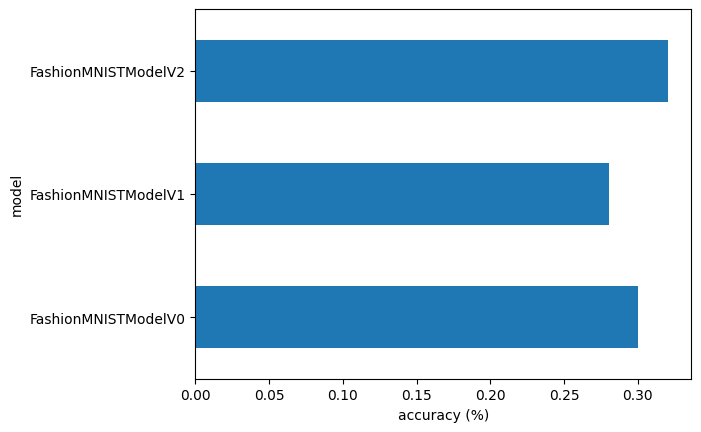

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind = "barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)

      # forward 
      pred_logit = model(sample)

      # Get prediction probaility
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      # Get pred_prob off GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)



print(f"Test sample image shape: {test_samples[0].shape}\Test sample label: {test_labels[0]} ({class_names[test_labels[0]]}")